# A joint Euclid–Rubin visual and astrometric consistency initial check

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astroquery.ipac.irsa import Irsa
import fsspec

from scipy.optimize import linear_sum_assignment
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, median_filter, zoom
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.coordinates import match_coordinates_sky
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from astropy.coordinates import search_around_sky


def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

def save_bundle(path, **kw):
    np.savez_compressed(path, **{k: v for k, v in kw.items() if v is not None})
    print("saved:", path)


def load_euclid_cutouts(
    ra, dec, size_arcsec,
    bands=("VIS", "Y", "J", "H"),
    collection="euclid_DpdMerBksMosaic",
    radius_arcsec=60,
):
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    tab = Irsa.query_sia(pos=(coord, radius_arcsec * u.arcsec), collection=collection).to_table()
    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]

    out = {b: None for b in bands}
    wcs_out = {}

    for b in bands:
        rows = tab[tab["energy_bandpassname"] == b] if "energy_bandpassname" in tab.colnames else tab
        if len(rows) == 0:
            continue

        url = rows["access_url"][0]

        with fsspec.open(url, "rb") as f:
            with fits.open(f, memmap=False) as hdul:
                wcs0 = WCS(hdul[0].header)
                cut = Cutout2D(hdul[0].data, coord, size_arcsec * u.arcsec, wcs=wcs0)
                out[b] = np.array(cut.data, dtype=np.float32)
                wcs_out[b] = cut.wcs  # cutout-aware WCS

    return out, wcs_out


def load_rubin_cutouts(
    ra, dec, size_arcsec, bands,
    repo="dp1",
    collection="LSSTComCam/DP1",
):
    butler = Butler(repo, collections=collection)

    pixscale = 0.2  # arcsec/pix (fine for this visual/astrometry check)
    n = int(np.round(size_arcsec / pixscale))
    if n % 2 == 1:
        n += 1

    imgs = {b: None for b in bands}
    wcs_local = {}  # <- WCS in CUTOUT pixel coords (0..N-1)

    for b in bands:
        refs = list(butler.query_datasets(
            "deep_coadd",
            where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
            bind={"band": b, "ra": ra, "dec": dec},
            with_dimension_records=True,
            order_by=["patch.tract"],
        ))
        if not refs:
            continue

        dataId = refs[0].dataId
        wcs_full = butler.get("deep_coadd.wcs", dataId=dataId)

        sp = geom.SpherePoint(ra, dec, geom.degrees)
        xy_full = geom.PointI(wcs_full.skyToPixel(sp))

        bbox = geom.BoxI(
            xy_full - geom.ExtentI(n, n)//2,
            geom.ExtentI(n, n)
        )

        cut = butler.get("deep_coadd", dataId=dataId, parameters={"bbox": bbox})
        imgs[b] = cut.image.array

        # --- key: make a WCS whose pixel (0,0) corresponds to bbox.min in the full image ---
        x0, y0 = bbox.getMinX(), bbox.getMinY()
        wcs_local[b] = wcs_full.copyAtShiftedPixelOrigin(geom.Extent2D(-x0, -y0))


    return imgs, wcs_local

### Target

In [2]:
ra, dec = 53.16, -28.10 #this is center of ECDFS (Rubin spans ~1degree diameter)
size_arcsec = 500.0
bands_rubin = ["u","g","r","i","z","y"]
bands_euclid = ["VIS","Y","J","H"]


## Multi-band data retrieval and Visualization

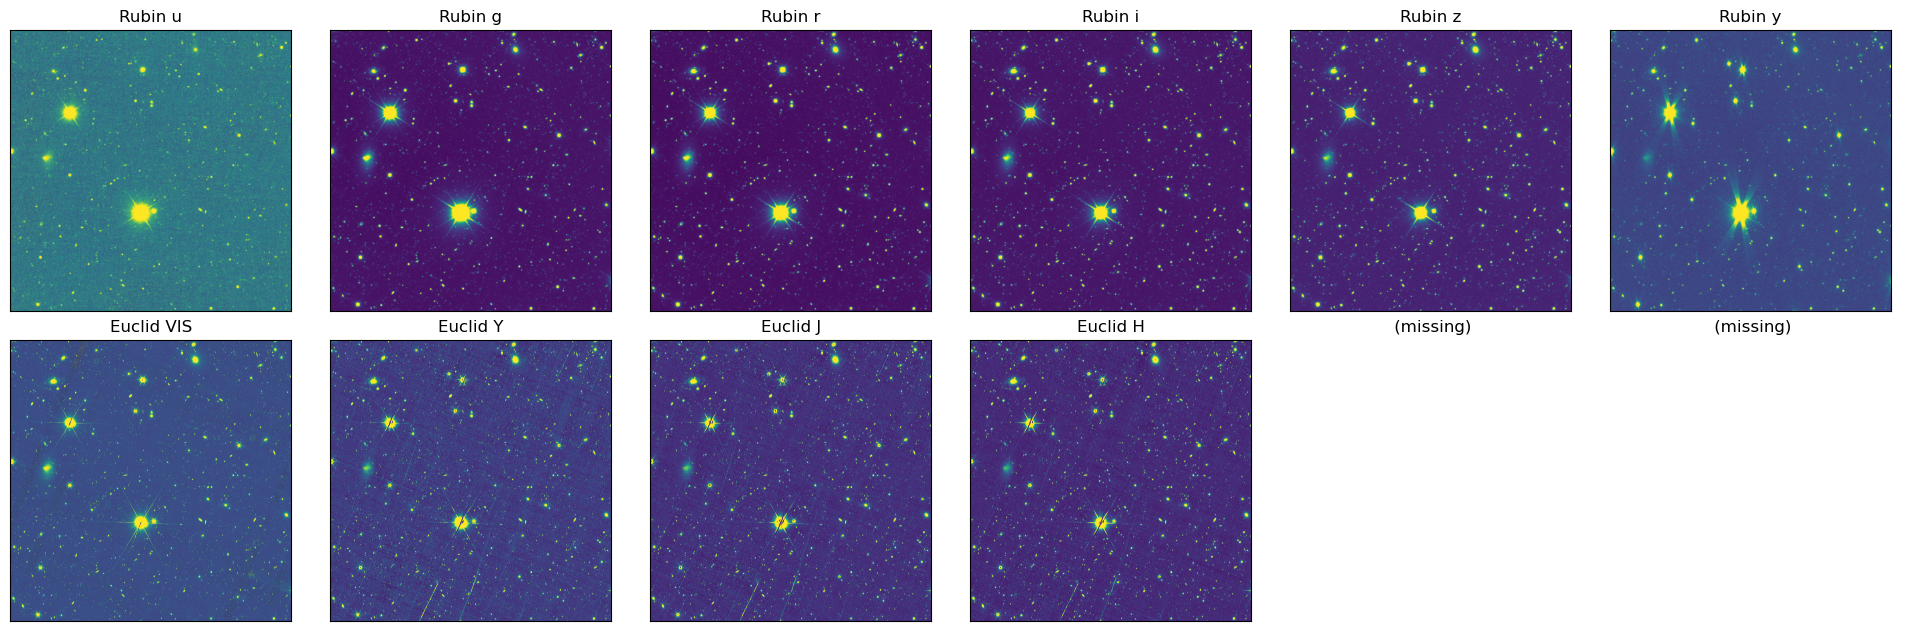

In [3]:
rub, rub_wcs = load_rubin_cutouts(ra, dec, size_arcsec, bands_rubin)
euc, euc_wcs = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)

ncol = max(len(bands_rubin), len(bands_euclid))
fig, axes = plt.subplots(2, ncol, figsize=(3.2*ncol, 6.2), constrained_layout=True)

for j in range(ncol):
    ax = axes[0, j]
    b = bands_rubin[j] if j < len(bands_rubin) else ""
    robust_imshow(ax, rub.get(b), f"Rubin {b}" if b else "")

for j in range(ncol):
    ax = axes[1, j]
    b = bands_euclid[j] if j < len(bands_euclid) else ""
    robust_imshow(ax, euc.get(b), f"Euclid {b}" if b else "")

plt.show()


## Source Detection and Cross-band Matching:

In [52]:
def find_peaks(img, nsigma=3.0, border=10, top=200, local_box=64):
    """
    Fast local robust threshold:
    - compute median + MAD on a coarse grid of blocks (local_box)
    - upsample maps back to full image
    """
    data = np.nan_to_num(img, nan=-np.inf)
    ny, nx = data.shape
    b = int(local_box)

    # Pad so we can reshape cleanly
    py = (-ny) % b
    px = (-nx) % b
    if py or px:
        data_p = np.pad(data, ((0, py), (0, px)), mode="edge")
    else:
        data_p = data

    Ny, Nx = data_p.shape
    by, bx = Ny // b, Nx // b

    # Block view: (by, b, bx, b)
    blocks = data_p.reshape(by, b, bx, b)

    # Robust local median and MAD per block
    m_blk = np.nanmedian(blocks, axis=(1, 3))
    mad_blk = np.nanmedian(np.abs(blocks - m_blk[:, None, :, None]), axis=(1, 3))
    s_blk = 1.4826 * mad_blk

    # Upsample block maps back to padded image size
    m = zoom(m_blk, (b, b), order=1)[:Ny, :Nx]
    s = zoom(s_blk, (b, b), order=1)[:Ny, :Nx]

    # Crop back to original
    m = m[:ny, :nx]
    s = s[:ny, :nx]

    thr = m + nsigma * s

    # Local maxima (still no PSF assumptions)
    local_max = maximum_filter(data, size=3) == data
    mask = (data > thr) & local_max & np.isfinite(data)

    # Remove border peaks
    if border and border > 0:
        mask[:border, :] = False; mask[-border:, :] = False
        mask[:, :border] = False; mask[:, -border:] = False

    ys, xs = np.where(mask)
    if xs.size == 0:
        return np.array([]), np.array([])

    vals = data[ys, xs]
    order = np.argsort(vals)[::-1]
    if top is not None:
        order = order[:top]

    return xs[order].astype(float), ys[order].astype(float)



# ---------- centroid refinement (replace center-of-mass) ----------
def _parabolic_subpixel_1d(fm1, f0, fp1):
    """
    Subpixel offset of a parabola peak given samples at -1,0,+1.
    Returns dx in [-0.5, 0.5] typically; 0 if curvature is degenerate.
    """
    denom = (fm1 - 2.0 * f0 + fp1)
    if denom == 0 or not np.isfinite(denom):
        return 0.0
    dx = 0.5 * (fm1 - fp1) / denom
    if not np.isfinite(dx):
        return 0.0
    return float(np.clip(dx, -0.75, 0.75))


def refine_centroids(img, xs, ys, r=5):
    """
    Refines peak positions using a robust local-maximum + quadratic (parabolic) subpixel interpolation.

    - Finds the brightest pixel in the cutout after local background subtraction.
    - Uses 1D parabolic interpolation in x and y around that pixel for subpixel offsets.
    """
    outx, outy = [], []
    ny, nx = img.shape

    data = np.nan_to_num(img, nan=-np.inf)

    for x0, y0 in zip(xs, ys):
        ix, iy = int(round(x0)), int(round(y0))
        y1, y2 = max(0, iy - r), min(ny, iy + r + 1)
        x1, x2 = max(0, ix - r), min(nx, ix + r + 1)

        cut = data[y1:y2, x1:x2]
        if cut.size == 0 or not np.isfinite(cut).any():
            outx.append(x0); outy.append(y0)
            continue

        # Local background subtraction (robust) and positivity clamp
        bkg = np.nanmedian(cut[np.isfinite(cut)])
        w = cut - bkg
        w = np.clip(w, 0, None)

        if np.sum(w) <= 0:
            outx.append(x0); outy.append(y0)
            continue

        # Pick the local brightest pixel in the window
        py, px = np.unravel_index(np.argmax(w), w.shape)

        # Need a 3x3 neighborhood for parabolic interpolation
        if py <= 0 or py >= w.shape[0] - 1 or px <= 0 or px >= w.shape[1] - 1:
            outx.append(x1 + px); outy.append(y1 + py)
            continue

        # Parabolic subpixel offsets using the *background-subtracted* weights
        f0 = w[py, px]
        dx = _parabolic_subpixel_1d(w[py, px - 1], f0, w[py, px + 1])
        dy = _parabolic_subpixel_1d(w[py - 1, px], f0, w[py + 1, px])

        outx.append(x1 + px + dx)
        outy.append(y1 + py + dy)

    return np.array(outx), np.array(outy)


# ---------- pixel -> sky  ----------
def pix_to_sky_rubin(wcs, x, y):
    """Rubin-specific pixel to sky conversion."""
    sp = wcs.pixelToSky(geom.Point2D(float(x), float(y)))
    return sp.getRa().asDegrees(), sp.getDec().asDegrees()

def pix_to_sky_astropy(wcs, x, y):
    """Astropy-specific pixel to sky conversion."""
    ra, dec = wcs.all_pix2world([[float(x), float(y)]], 0)[0]
    return float(ra), float(dec)

def skycoords_from_peaks(img, wcs, kind="rubin", nsigma=5,
                         top=None, max_density=10, border=10, refine_r=5,
                         local_box=64):
    """
    Full pipeline: Find peaks -> Refine -> Project to SkyCoords.

    max_density : float
        Maximum sources per square arcminute (used only if top is None).
    local_box : int
        Local background/MAD box (pixels) for detection thresholding.
    """
    xs, ys = find_peaks(img, nsigma=nsigma, border=border, top=None, local_box=local_box)  # Find ALL

    if xs.size == 0:
        return SkyCoord([], [], unit="deg", frame="icrs")

    # Calculate image area in square arcminutes (best-effort)
    if hasattr(wcs, 'pixel_scale_matrix'):
        pixel_scale = np.sqrt(np.abs(np.linalg.det(wcs.pixel_scale_matrix))) * 3600  # arcsec/pix
    else:
        pixel_scale = 0.2  # fallback
    area_arcsec2 = (img.shape[0] * pixel_scale) * (img.shape[1] * pixel_scale)
    area_arcmin2 = area_arcsec2 / 3600.0

    if top is None:
        top = int(max_density * area_arcmin2)
        print(f"Auto-limiting to {top} brightest sources ({max_density:.1f} per arcmin²)")

    # Sort by brightness BEFORE refinement (using integer indices)
    if xs.size > top:
        xs_int = np.round(xs).astype(int)
        ys_int = np.round(ys).astype(int)
        xs_int = np.clip(xs_int, 0, img.shape[1] - 1)
        ys_int = np.clip(ys_int, 0, img.shape[0] - 1)
        peak_values = img[ys_int, xs_int]  # [y, x]
        sort_idx = np.argsort(peak_values)[-top:]
        xs, ys = xs[sort_idx], ys[sort_idx]

    # NOW refine centroids
    if refine_r and refine_r > 0:
        xs, ys = refine_centroids(img, xs, ys, r=refine_r)

    # Convert to sky coordinates
    if kind == "rubin":
        ra, dec = [], []
        for x, y in zip(xs, ys):
            r, d = pix_to_sky_rubin(wcs, x, y)
            ra.append(r)
            dec.append(d)
    else:
        radec = wcs.all_pix2world(np.column_stack([xs, ys]), 0)
        ra, dec = radec[:, 0], radec[:, 1]

    return SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")


# ---------- matching improvements: affine pre-alignment + residual-space cut ----------
def _sky_to_tangent_arcsec(sky, center):
    """
    Project SkyCoord to a local tangent-plane-ish offset (arcsec) around `center`,
    using spherical offsets (good for small fields).
    Returns Nx2 array [dx, dy] in arcsec.
    """
    dlon, dlat = center.spherical_offsets_to(sky)  # radians
    dx = dlon.to(u.arcsec).value
    dy = dlat.to(u.arcsec).value
    return np.column_stack([dx, dy])

def _fit_affine_iterative(ref_xy, cand_xy, pairs, n_iter=3, clip_sigma=3.0):
    """
    Fit affine transform from ref_xy -> cand_xy using iterative robust clipping.

    Model:
        x' = a x + b y + c
        y' = d x + e y + f
    """
    if pairs.shape[0] < 3:
        return None  # not enough

    A = []
    B = []
    for i_ref, i_cand in pairs:
        x, y = ref_xy[i_ref]
        xp, yp = cand_xy[i_cand]
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        B.append(xp)
        B.append(yp)
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)

    keep = np.ones(len(B), dtype=bool)

    params = None
    for _ in range(n_iter):
        Ak = A[keep]
        Bk = B[keep]
        if Ak.shape[0] < 6:
            break
        params, *_ = np.linalg.lstsq(Ak, Bk, rcond=None)

        # compute residuals for each pair (in arcsec)
        a, b, c, d, e, f = params
        x = ref_xy[pairs[:, 0], 0]
        y = ref_xy[pairs[:, 0], 1]
        xp = cand_xy[pairs[:, 1], 0]
        yp = cand_xy[pairs[:, 1], 1]
        xhat = a * x + b * y + c
        yhat = d * x + e * y + f
        res = np.sqrt((xhat - xp) ** 2 + (yhat - yp) ** 2)

        med = np.median(res)
        sig = 1.4826 * np.median(np.abs(res - med))
        if sig <= 0 or not np.isfinite(sig):
            break

        good_pairs = (res < med + clip_sigma * sig)
        keep_pairs = np.repeat(good_pairs, 2)  # because A/B are doubled rows
        if keep_pairs.sum() == keep.sum():
            break
        keep = keep_pairs

    return params

def hungarian_match(ref_sky, cand_sky, max_sep_arcsec=0.4):
    """
    Matching with:
      (1) affine pre-alignment in tangent plane (handles rotation/scale/shear-ish)
      (2) Hungarian assignment on residual distances
      (3) robust residual-space coherence cut
    """
    if len(ref_sky) == 0 or len(cand_sky) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])

    # Tangent-plane coordinates (arcsec) around ref median center
    center = SkyCoord(np.median(ref_sky.ra), np.median(ref_sky.dec), frame="icrs")
    ref_xy = _sky_to_tangent_arcsec(ref_sky, center)
    cand_xy = _sky_to_tangent_arcsec(cand_sky, center)

    # ---- 1) Build rough pair set with a *looser* radius, then fit affine
    loose = max_sep_arcsec * 5.0
    idx_ref, idx_cand, sep2d, _ = ref_sky.search_around_sky(cand_sky, loose * u.arcsec)
    # NOTE: search_around_sky returns (idx_self, idx_other) in that order:
    # Here: cand_sky.search_around_sky(ref_sky, ...) would swap.
    # With ref_sky.search_around_sky(cand_sky, ...):
    # idx_ref are indices into ref_sky, idx_cand into cand_sky.
    if len(idx_ref) >= 6:
        pairs = np.column_stack([idx_ref, idx_cand])
        params = _fit_affine_iterative(ref_xy, cand_xy, pairs, n_iter=3, clip_sigma=3.0)
    else:
        params = None

    # Apply affine transform to ref points (or identity if unavailable)
    if params is None:
        ref_xy_w = ref_xy
    else:
        a, b, c, d, e, f = params
        x = ref_xy[:, 0]; y = ref_xy[:, 1]
        ref_xy_w = np.column_stack([a * x + b * y + c, d * x + e * y + f])

    # ---- 2) Cost matrix in residual space (arcsec)
    dx = ref_xy_w[:, None, 0] - cand_xy[None, :, 0]
    dy = ref_xy_w[:, None, 1] - cand_xy[None, :, 1]
    dist = np.sqrt(dx * dx + dy * dy)

    cost = np.where(dist <= max_sep_arcsec, dist, 1e6)
    r, c = linear_sum_assignment(cost)

    # Keep feasible matches
    ok = cost[r, c] < 1e5
    r, c = r[ok], c[ok]

    if len(r) < 5:
        # return true on-sky separations for those matches
        seps = ref_sky[r].separation(cand_sky[c]).to(u.arcsec).value
        return r, c, seps

    # ---- 3) Robust residual-space coherence cut (after affine)
    resid = dist[r, c]  # arcsec residuals in tangent plane
    med = np.median(resid)
    sig = 1.4826 * np.median(np.abs(resid - med))
    if not np.isfinite(sig) or sig <= 0:
        seps = ref_sky[r].separation(cand_sky[c]).to(u.arcsec).value
        return r, c, seps

    coherent = resid < (med + 3.0 * sig)

    r2, c2 = r[coherent], c[coherent]
    seps = ref_sky[r2].separation(cand_sky[c2]).to(u.arcsec).value
    return r2, c2, seps
    
def nn_greedy_unique_match(ref_sky, cand_sky, max_sep_arcsec=0.1):
    """
    One-to-one greedy matching within max_sep.
    Returns (ri, ci, sep_arcsec) where:
      ri indexes ref_sky
      ci indexes cand_sky
    """
    if len(ref_sky) == 0 or len(cand_sky) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])

    # Explicit ordering: idx_ref indexes ref_sky, idx_cand indexes cand_sky
    idx_ref, idx_cand, sep2d, _ = search_around_sky(ref_sky, cand_sky, max_sep_arcsec * u.arcsec)

    if len(idx_ref) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])

    sep = sep2d.to(u.arcsec).value
    order = np.argsort(sep)

    used_ref = np.zeros(len(ref_sky), dtype=bool)
    used_cand = np.zeros(len(cand_sky), dtype=bool)

    ri_out, ci_out, sep_out = [], [], []
    for k in order:
        r = int(idx_ref[k])
        c = int(idx_cand[k])
        if used_ref[r] or used_cand[c]:
            continue
        used_ref[r] = True
        used_cand[c] = True
        ri_out.append(r)
        ci_out.append(c)
        sep_out.append(sep[k])

    return np.array(ri_out, dtype=int), np.array(ci_out, dtype=int), np.array(sep_out, dtype=float)


In [55]:
# Diagnostic: See how many sources are detected before limiting
def count_detections(img, nsigma=10, border=0, local_box=100):
    xs, ys = find_peaks(img, nsigma=nsigma, border=border, top=None, local_box=local_box)
    return len(xs)

# Rubin bands
for b in ["u", "g", "r", "i", "z","y"]:
    n = count_detections(rub[b], nsigma=10, border=0, local_box=100)
    print(f"Rubin {b}: {n} total detections above 10σ (local MAD)")

# Euclid bands
for b in ["VIS", "Y", "J", "H"]:
    n = count_detections(euc[b], nsigma=10, border=0, local_box=100)
    print(f"Euclid {b}: {n} total detections above 10σ (local MAD)")


Rubin u: 108 total detections above 10σ (local MAD)
Rubin g: 1384 total detections above 10σ (local MAD)
Rubin r: 1497 total detections above 10σ (local MAD)
Rubin i: 1422 total detections above 10σ (local MAD)
Rubin z: 997 total detections above 10σ (local MAD)
Rubin y: 296 total detections above 10σ (local MAD)
Euclid VIS: 5631 total detections above 10σ (local MAD)
Euclid Y: 2554 total detections above 10σ (local MAD)
Euclid J: 2850 total detections above 10σ (local MAD)
Euclid H: 3023 total detections above 10σ (local MAD)


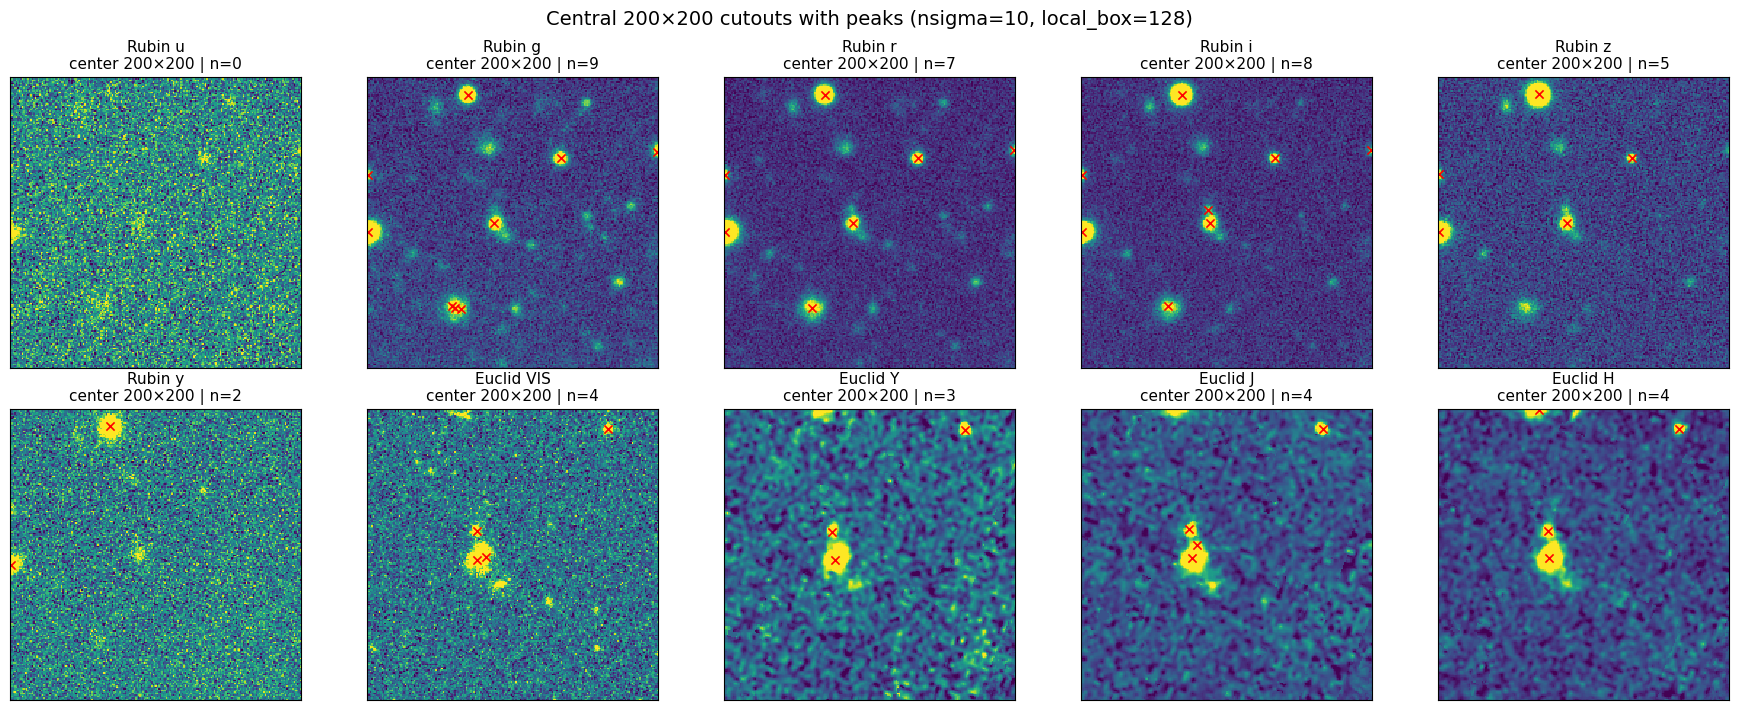

In [56]:
def _robust_vmin_vmax(img, p_lo=1, p_hi=99):
    finite = img[np.isfinite(img)]
    if finite.size == 0:
        return 0.0, 1.0
    vmin, vmax = np.percentile(finite, [p_lo, p_hi])
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = np.min(finite), np.max(finite)
        if vmin == vmax:
            vmin, vmax = vmin - 1.0, vmax + 1.0
    return float(vmin), float(vmax)

def plot_central_cutouts_with_peaks(
    rub, euc,
    bands_rub=("u","g","r","i","z","y"),
    bands_euc=("VIS","Y","J","H"),
    cut=200,
    nsigma=5,
    border=10,
    local_box=128,
    top=None,
):
    panels = []
    for b in bands_rub:
        if b in rub and rub[b] is not None:
            panels.append((f"Rubin {b}", rub[b]))
    for b in bands_euc:
        if b in euc and euc[b] is not None:
            panels.append((f"Euclid {b}", euc[b]))

    n = len(panels)
    if n == 0:
        raise ValueError("No bands found in rub/euc dictionaries.")

    ncols = 5 if n >= 5 else n
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.6*ncols, 3.6*nrows), squeeze=False)

    for i, (title, img) in enumerate(panels):
        ax = axes[i // ncols][i % ncols]
        ny, nx = img.shape
        if ny < cut or nx < cut:
            ax.axis("off")
            continue

        y0 = ny // 2 - cut // 2
        x0 = nx // 2 - cut // 2
        cut_img = img[y0:y0+cut, x0:x0+cut]

        xs, ys = find_peaks(cut_img,nsigma=nsigma,border=0,top=top,local_box=min(local_box, cut))

        vmin, vmax = _robust_vmin_vmax(cut_img, 1, 99)
        ax.imshow(cut_img, origin="lower", vmin=vmin, vmax=vmax, interpolation="nearest")
        if xs.size:
            ax.scatter(xs, ys, marker="x", s=35, c="red", linewidths=1.2)

        ax.set_title(f"{title}\ncenter {cut}×{cut} | n={len(xs)}", fontsize=11)
        ax.set_xticks([]); ax.set_yticks([])

    for j in range(n, nrows*ncols):
        axes[j // ncols][j % ncols].axis("off")

    fig.suptitle(f"Central {cut}×{cut} cutouts with peaks (nsigma={nsigma}, local_box={local_box})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example:
plot_central_cutouts_with_peaks(rub, euc, cut=200, nsigma=10, local_box=128)


In [58]:
ref = skycoords_from_peaks(euc["VIS"], euc_wcs["VIS"], kind="astropy", nsigma=10, top=5000, local_box=128)

catalogs = {}
max_sep = 0.1  # arcsec

for b in ["u", "g", "r", "i", "z", "y"]:
    cand = skycoords_from_peaks(rub[b], rub_wcs[b],kind="rubin", nsigma=10, top=5000, local_box=128)
    ri, ci, sep = nn_greedy_unique_match(ref, cand, max_sep_arcsec=max_sep)
    catalogs[b] = (cand, ri, ci, sep)

for b in ["Y", "J", "H"]:
    cand = skycoords_from_peaks(euc[b], euc_wcs[b], kind="astropy", nsigma=10, top=5000, local_box=128)
    ri, ci, sep = nn_greedy_unique_match(ref, cand, max_sep_arcsec=max_sep)
    catalogs[b] = (cand, ri, ci, sep)


## Astrometric residual contours vs Euclid VIS:

In [69]:
def _mad_sigma(x):
    med = np.median(x)
    return 1.4826 * np.median(np.abs(x - med))

def plot_all_bands_astrometry_diagnostic(
    ref, catalogs, ref_name="Euclid VIS",
    view_limit=100, remove_systematic_offset=False,
    max_points_per_band=20000,
    show_scatter=False,              # contours-only looks cleaner for this
    n_bins=45,                       # higher resolution histogram
    smooth_sigma=2.2,                # smoother contours
    clip_sigma=3.5,                  # robust outlier clip per band
    min_points_for_contour=80,
):
    band_colors = {
        'u': '#0B1F3A', 'g': '#143A6F', 'r': '#1F5FA3', 'i': '#4B8FD1', 'z': '#8FC6FF', 'y': '#00FFFF',
        'Y': '#B7B8FF', 'J': '#E3A6D9', 'H': '#F2A37B',
    }
    band_order = ['u', 'g', 'r', 'i', 'z', 'y', 'Y', 'J', 'H']

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor('#6D6D6D')
    ax.set_xlim(-view_limit, view_limit)
    ax.set_ylim(-view_limit, view_limit)

    ax.grid(True, alpha=0.2, color='white', linewidth=0.5)
    ax.axhline(0, color='white', linestyle='--', alpha=0.5, linewidth=1)
    ax.axvline(0, color='white', linestyle='--', alpha=0.5, linewidth=1)

    print(f"\n{'Band':<6} {'N_used':<8} {'N_all':<8} {'Median offset':<15} {'RMS':<10} {'MADσ_RA/Dec':<18}")
    print("-" * 80)

    handles = []

    for band_name in band_order:
        if band_name not in catalogs:
            continue

        item = catalogs[band_name]
        if len(item) == 3:
            cand_coords, ri, ci = item
        elif len(item) == 4:
            cand_coords, ri, ci, _ = item
        else:
            raise ValueError(f"catalogs['{band_name}'] must be (cand,ri,ci) or (cand,ri,ci,sep); got len={len(item)}")

        if len(ri) == 0:
            continue

        matched_ref  = ref[ri]
        matched_cand = cand_coords[ci]

        cosdec = np.cos(np.radians(matched_ref.dec.deg))
        dra = (matched_cand.ra.deg - matched_ref.ra.deg) * 3600.0 * 1000.0 * cosdec
        ddec = (matched_cand.dec.deg - matched_ref.dec.deg) * 3600.0 * 1000.0

        med_ra = np.median(dra)
        med_dec = np.median(ddec)

        if remove_systematic_offset:
            dra = dra - med_ra
            ddec = ddec - med_dec

        # --- robust outlier clip (kills floating islands) ---
        sig_ra = _mad_sigma(dra)
        sig_dec = _mad_sigma(ddec)
        # avoid division by zero
        sig_ra = sig_ra if sig_ra > 0 else np.std(dra) + 1e-9
        sig_dec = sig_dec if sig_dec > 0 else np.std(ddec) + 1e-9

        keep = (np.abs(dra - np.median(dra)) < clip_sigma * sig_ra) & \
               (np.abs(ddec - np.median(ddec)) < clip_sigma * sig_dec)

        dra_k = dra[keep]
        ddec_k = ddec[keep]

        # cap for plotting speed
        if (max_points_per_band is not None) and (len(dra_k) > max_points_per_band):
            sel = np.random.choice(len(dra_k), size=max_points_per_band, replace=False)
            dra_k = dra_k[sel]
            ddec_k = ddec_k[sel]

        median_offset = np.hypot(med_ra, med_dec)
        rms = np.sqrt(np.mean(dra_k**2 + ddec_k**2)) if len(dra_k) else np.nan

        print(f"{band_name:<6} {len(dra_k):<8} {len(ri):<8} {median_offset:>13.2f}   "
              f"{rms:>8.2f}   {sig_ra:5.1f}/{sig_dec:5.1f}")

        color = band_colors.get(band_name, '#FFFFFF')

        # optional scatter (usually off)
        if show_scatter and len(dra_k):
            ax.scatter(dra_k, ddec_k, c=color, s=6, alpha=0.18, edgecolors='none', rasterized=True)

        # contour (single main island, smoother)
        if len(dra_k) >= min_points_for_contour:
            H, xedges, yedges = np.histogram2d(dra_k, ddec_k, bins=n_bins,
                                               range=[[-view_limit, view_limit], [-view_limit, view_limit]])
            H = gaussian_filter(H.T, sigma=smooth_sigma)

            if H.max() > 0:
                # Use a stable level: fraction of peak avoids “fragmenting” at low counts
                level = 0.20 * H.max()
                xc = 0.5 * (xedges[:-1] + xedges[1:])
                yc = 0.5 * (yedges[:-1] + yedges[1:])
                X, Y = np.meshgrid(xc, yc)
                ax.contour(X, Y, H, levels=[level], colors=color, linewidths=2.5, alpha=1.0)

        handles.append(mpatches.Patch(color=color, label=f"{band_name} (n={len(dra_k)})"))

    ax.set_xlabel(f'Astrometric shift vs {ref_name} (R.A.) [mas]', fontsize=13)
    ax.set_ylabel(f'Astrometric shift vs {ref_name} (Declination) [mas]', fontsize=13)

    if handles:
        ax.legend(handles=handles, loc='center left',
                  fontsize=11, framealpha=0.95, facecolor='white')

    ax.text(0.02, 0.98, "Contours after robust clipping\n(one-to-one greedy matches)",
            transform=ax.transAxes, fontsize=11, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    plt.tight_layout()
    return fig, ax



Band   N_used   N_all    Median offset   RMS        MADσ_RA/Dec       
--------------------------------------------------------------------------------
u      33       33               39.66      63.03    37.6/ 40.9
g      586      586              14.82      56.09    37.9/ 36.0
r      793      793              13.22      54.51    34.3/ 33.3
i      806      809              16.23      51.56    32.1/ 30.1
z      582      582               6.91      49.96    29.4/ 33.4
y      163      166              11.70      50.08    26.0/ 25.9
Y      977      977               8.92      62.80    41.6/ 45.7
J      1076     1076              2.13      63.48    47.2/ 46.9
H      1077     1077              2.87      63.27    42.4/ 46.5


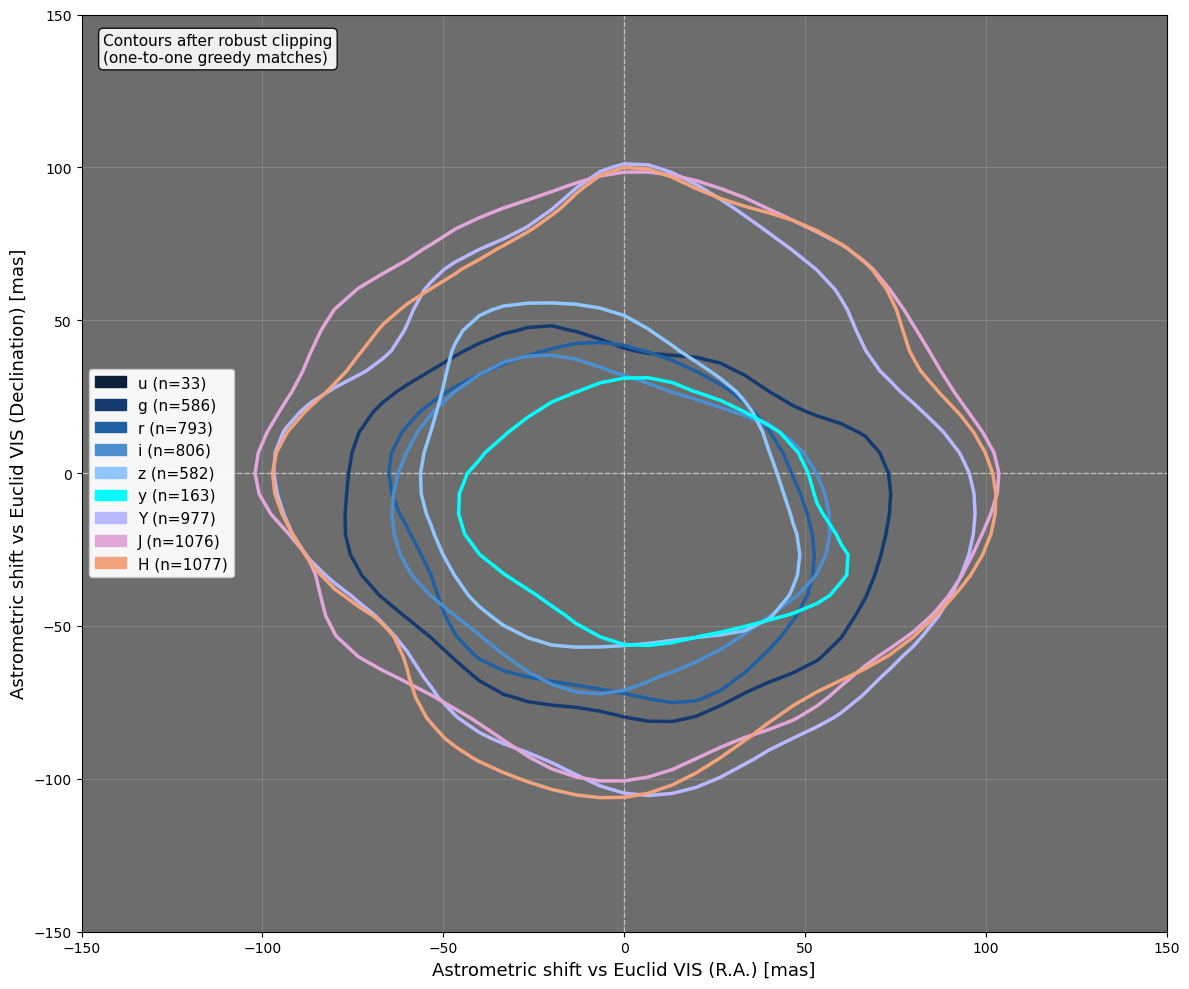

In [70]:
fig,ax = plot_all_bands_astrometry_diagnostic(ref, catalogs, remove_systematic_offset=False, view_limit=150)

plt.savefig('astrometry_all_bands_both.png', dpi=200, bbox_inches='tight')
plt.show()

## Spatial structure of astrometric residuals relative to Euclid VIS

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spatial_offsets_vs_vis_cellsize(pos_series, which="Rubin i",
                                        cell_arcsec=20.0, min_count=10,
                                        stat="median", vmax=None,
                                        show_counts=True, robust_vmax_q=98):
    """
    Spatial map of astrometric offset magnitude vs Euclid VIS.

    Expects pos_series items: (name, ra, dec, dra_mas, ddec_mas)
      - ra/dec in deg
      - dra_mas, ddec_mas in mas (RA already includes cos(dec) correction, as in your other plot)
    """

    # pick series
    for name, ra, dec, dra, ddec in pos_series:
        if name == which:
            ra = np.asarray(ra); dec = np.asarray(dec)
            dra = np.asarray(dra); ddec = np.asarray(ddec)
            break
    else:
        raise ValueError(f"{which} not found in pos_series")

    # local tangent-ish plane for binning (arcsec)
    ra0 = np.median(ra)
    dec0 = np.median(dec)
    x = (ra - ra0) * np.cos(np.deg2rad(dec0)) * 3600.0  # arcsec
    y = (dec - dec0) * 3600.0                           # arcsec

    # astrometric offset magnitude (mas)
    r_mas = np.hypot(dra, ddec)

    # define grid edges
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    ymin, ymax = np.nanmin(y), np.nanmax(y)

    xb = np.arange(np.floor(xmin/cell_arcsec)*cell_arcsec,
                   np.ceil (xmax/cell_arcsec)*cell_arcsec + cell_arcsec,
                   cell_arcsec)
    yb = np.arange(np.floor(ymin/cell_arcsec)*cell_arcsec,
                   np.ceil (ymax/cell_arcsec)*cell_arcsec + cell_arcsec,
                   cell_arcsec)

    nx, ny = len(xb)-1, len(yb)-1

    # bin assignment
    ix = np.digitize(x, xb) - 1
    iy = np.digitize(y, yb) - 1
    good = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(r_mas)

    ix = ix[good]; iy = iy[good]; r_mas = r_mas[good]
    cid = iy * nx + ix
    ncell = nx * ny

    cnt_flat = np.bincount(cid, minlength=ncell)
    grid_flat = np.full(ncell, np.nan, dtype=float)

    # compute stat per cell (median or 68th percentile)
    order = np.argsort(cid)
    cid_s = cid[order]
    v_s = r_mas[order]

    boundaries = np.flatnonzero(np.r_[True, cid_s[1:] != cid_s[:-1], True])
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        cell = cid_s[a]
        if cnt_flat[cell] < min_count:
            continue
        vals = v_s[a:b]
        if stat == "median":
            grid_flat[cell] = np.median(vals)
        elif stat == "p68":
            grid_flat[cell] = np.quantile(vals, 0.68)
        else:
            raise ValueError("stat must be 'median' or 'p68'")

    grid = grid_flat.reshape(ny, nx)
    cnt  = cnt_flat.reshape(ny, nx)

    # robust vmax
    if vmax is None:
        finite = grid[np.isfinite(grid)]
        if finite.size:
            vmax = np.percentile(finite, robust_vmax_q)

    # plot
    fig, ax = plt.subplots(figsize=(7.4, 6.3))
    im = ax.imshow(
        grid, origin="lower",
        extent=[xb[0], xb[-1], yb[0], yb[-1]],
        vmin=0.0, vmax=vmax, aspect="equal",
        interpolation="nearest"
    )
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(f"{stat} |Δ| (mas)")

    if show_counts:
        xc = 0.5*(xb[:-1] + xb[1:])
        yc = 0.5*(yb[:-1] + yb[1:])
        for j in range(ny):
            for i in range(nx):
                if cnt[j, i] >= min_count:
                    ax.text(xc[i], yc[j], f"{cnt[j,i]}",
                            ha="center", va="center", fontsize=8,
                            color="white", alpha=0.9)

    ax.axhline(0, color="white", lw=1, alpha=0.5)
    ax.axvline(0, color="white", lw=1, alpha=0.5)
    ax.set_xlabel("ΔRA·cos(dec) (arcsec) from cutout center")
    ax.set_ylabel("ΔDec (arcsec) from cutout center")
    ax.set_title(f"Spatial astrometric offset vs Euclid VIS: {which}  (cell={cell_arcsec:.0f}\")")
    plt.tight_layout()
    plt.show()


In [79]:
pos_series = []
for band, item in catalogs.items():
    if len(item) == 3:
        cand, ri, ci = item
    else:
        cand, ri, ci, _ = item
    if len(ri) == 0:
        continue

    ref_m = ref[ri]
    cand_m = cand[ci]

    ra  = ref_m.ra.deg
    dec = ref_m.dec.deg

    dra_mas  = (cand_m.ra.deg - ref_m.ra.deg) * 3600.0 * 1000.0 * np.cos(np.deg2rad(ref_m.dec.deg))
    ddec_mas = (cand_m.dec.deg - ref_m.dec.deg) * 3600.0 * 1000.0

    pos_series.append((band, ra, dec, dra_mas, ddec_mas))


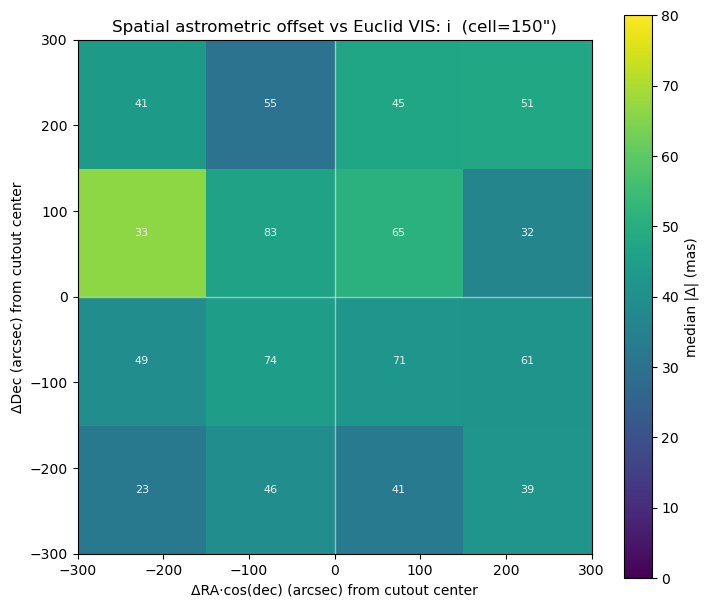

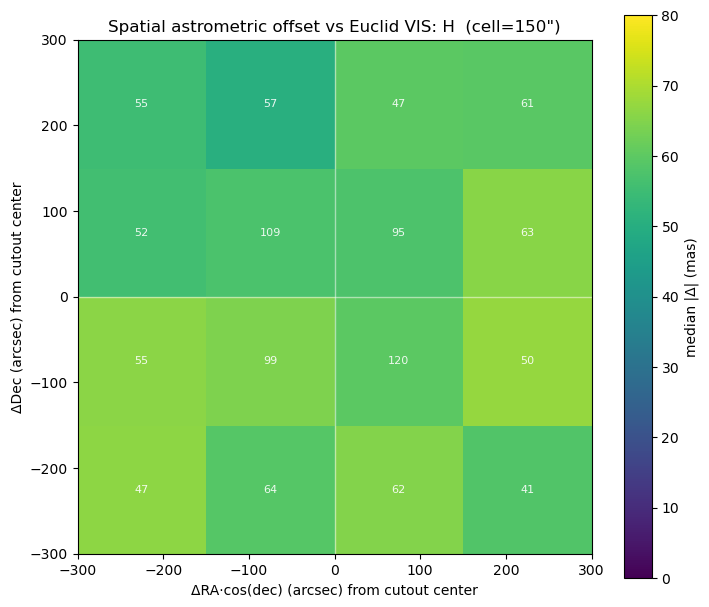

In [81]:
plot_spatial_offsets_vs_vis_cellsize(pos_series, which="i", cell_arcsec=150, min_count=5, stat="median", vmax=80)
plot_spatial_offsets_vs_vis_cellsize(pos_series, which="H", cell_arcsec=150, min_count=5, stat="median", vmax=80)
